<a href="https://colab.research.google.com/github/pachterlab/CGP_2024_2/blob/main/combinatorial_prediction_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**In this notebook we will test different predictive models of combinatorial perturbation behaviors using dual gRNA/CRISPRa conditions. This will demonstrate how to identify potential models of combinatorial regulation at the level of kinetic parameters.**

## **Read in data and metadata**

In [1]:
#Install
!pip install --quiet monod
!pip install -U --quiet loompy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.6/64.6 kB 898.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.4/124.4 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 15.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 1.6 MB/s eta 0:00:00


In [2]:
#metadata
!wget --content-disposition https://github.com/pachterlab/CGP_2024_2/raw/main/metadata/stoch_metadata.tar.gz
!tar -xvf stoch_metadata.tar.gz

#gene length annotation
!wget --content-disposition https://github.com/pachterlab/CGP_2024_2/raw/main/reference/gg_200525_genome_polyA_cum_3

#loom files
!wget --content-disposition https://data.caltech.edu/records/z3qv2-15815/files/example_looms.tar.gz?download=1
!tar -xvf example_looms.tar.gz

--2024-07-06 16:07:55--  https://github.com/pachterlab/CGP_2024_2/raw/main/metadata/stoch_metadata.tar.gz
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pachterlab/CGP_2024_2/main/metadata/stoch_metadata.tar.gz [following]
--2024-07-06 16:07:55--  https://raw.githubusercontent.com/pachterlab/CGP_2024_2/main/metadata/stoch_metadata.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2058737 (2.0M) [application/octet-stream]
Saving to: ‘stoch_metadata.tar.gz’

stoch_metadata.tar. 100%[===================>]   1.96M  --.-KB/s    in 0.04s   

2024-07-06 16:07:55 (46.5 MB/s) - ‘stoch_metadata.tar.

In [3]:
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis

/usr/local/lib/python3.10/dist-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/usr/local/lib/python3.10/dist-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str) -> int:
/usr/local/lib/python3.10/dist-packages/loompy/bus_file.py:1

In [4]:
import pandas as pd
import numpy as np
import loompy as lp
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import scipy.stats

import random
import glob
import os

## **Run *Monod* inference on loom files**

Set up files for Monod run and set cell barcode filters for desired conditions

In [5]:
meta = pd.read_csv('./norman_GSE133344_filtered_cell_identities.csv') #Metadata for cells from study


In [6]:

#Select individual control conditions, CBL/CNN1 conditions, and all controls combined
subcluster_names = [['NegCtrl10_NegCtrl0__NegCtrl10_NegCtrl0'],['NegCtrl11_NegCtrl0__NegCtrl11_NegCtrl0'],
                   ['NegCtrl1_NegCtrl0__NegCtrl1_NegCtrl0'],['NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0'],
                   ['CBL_NegCtrl0__CBL_NegCtrl0'],['CBL_CNN1__CBL_CNN1'],
                   ['NegCtrl0_CNN1__NegCtrl0_CNN1','CNN1_NegCtrl0__CNN1_NegCtrl0'],
                   ['NegCtrl10_NegCtrl0__NegCtrl10_NegCtrl0','NegCtrl11_NegCtrl0__NegCtrl11_NegCtrl0',
                    'NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0']]

sub_names_only = ['_'.join(n) for n in subcluster_names]

cluster_names = []
dataset_names = sub_names_only   #To save
print('dataset_names: ', dataset_names)
print('len(dataset_names): ',len(dataset_names))
print()


transcriptome_filepath = './gg_200525_genome_polyA_cum_3'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

loom_filepaths = ['./allcrispr_sub.loom']*len(dataset_names)
print('loom_filepaths: ',loom_filepaths)

n_datasets = len(loom_filepaths)

dataset_names:  ['NegCtrl10_NegCtrl0__NegCtrl10_NegCtrl0', 'NegCtrl11_NegCtrl0__NegCtrl11_NegCtrl0', 'NegCtrl1_NegCtrl0__NegCtrl1_NegCtrl0', 'NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0', 'CBL_NegCtrl0__CBL_NegCtrl0', 'CBL_CNN1__CBL_CNN1', 'NegCtrl0_CNN1__NegCtrl0_CNN1_CNN1_NegCtrl0__CNN1_NegCtrl0', 'NegCtrl10_NegCtrl0__NegCtrl10_NegCtrl0_NegCtrl11_NegCtrl0__NegCtrl11_NegCtrl0_NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0']
len(dataset_names):  8

loom_filepaths:  ['./allcrispr_sub.loom', './allcrispr_sub.loom', './allcrispr_sub.loom', './allcrispr_sub.loom', './allcrispr_sub.loom', './allcrispr_sub.loom', './allcrispr_sub.loom', './allcrispr_sub.loom']


In [7]:
cf = [] #Get cell barcodes for each condition


for k in range(len(dataset_names)):
    filename = loom_filepaths[k]

    with lp.connect(filename,mode='r') as ds:
        bcs = ds.ca[cell_attr]

    annot_bcs = meta[(meta['guide_identity'].isin(subcluster_names[k]))]['cell_barcode']
    cf.append(np.isin(bcs,annot_bcs))
    print(f'\t{len(annot_bcs)} cells in annotations. {np.isin(bcs,annot_bcs).sum()} selected.')



	3532 cells in annotations. 3532 selected.
	2839 cells in annotations. 2839 selected.
	2948 cells in annotations. 2948 selected.
	2536 cells in annotations. 2536 selected.
	663 cells in annotations. 663 selected.
	348 cells in annotations. 348 selected.
	765 cells in annotations. 765 selected.
	8907 cells in annotations. 8907 selected.


**Set up *Monod* and select 500 genes to fit across all conditions**

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


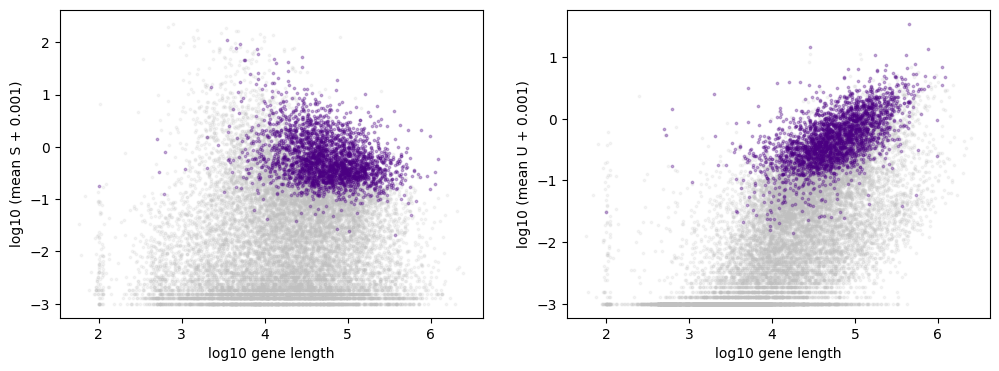

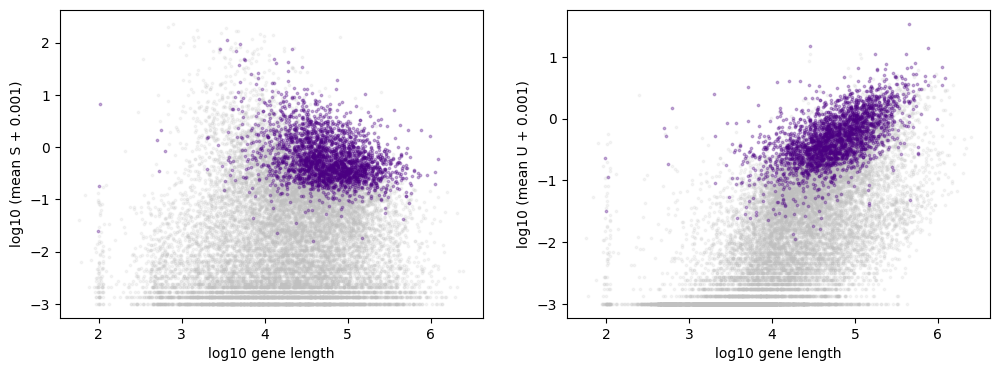

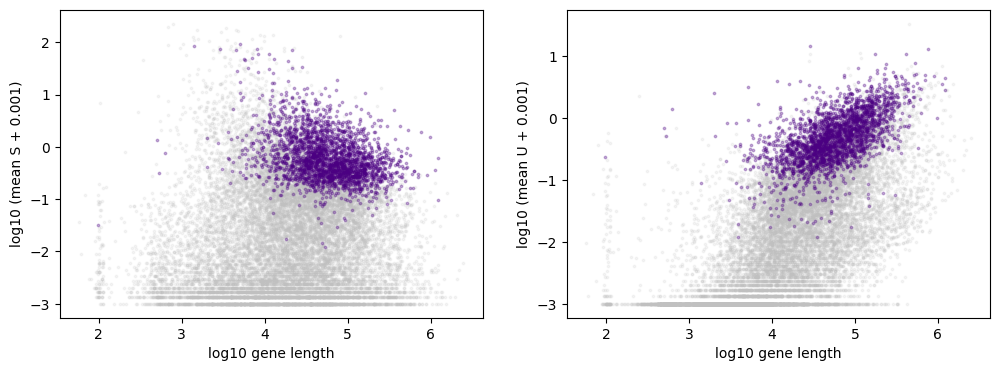

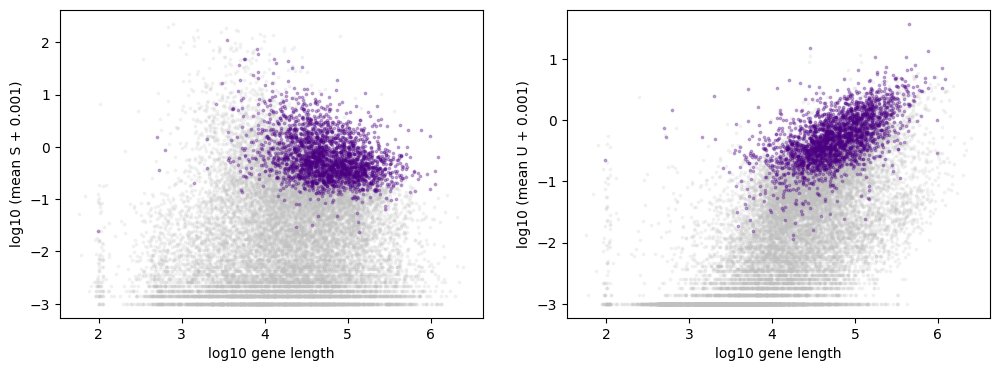

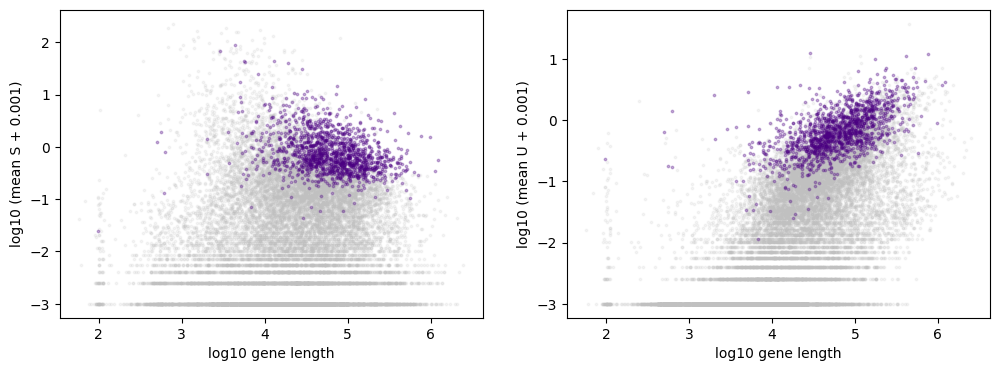

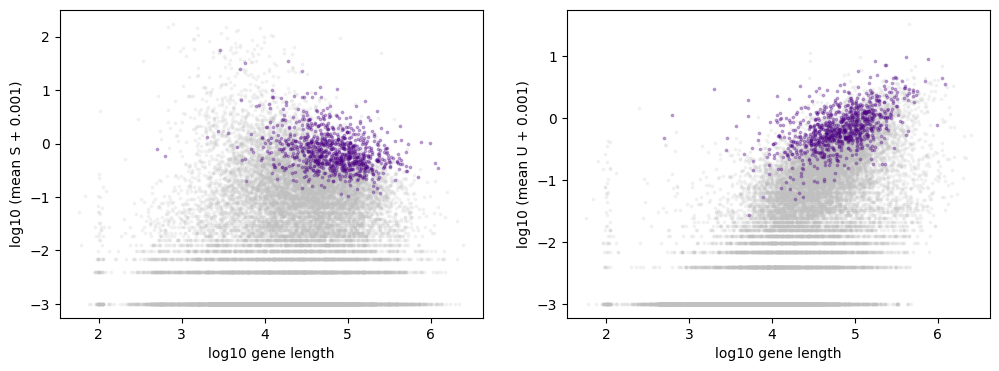

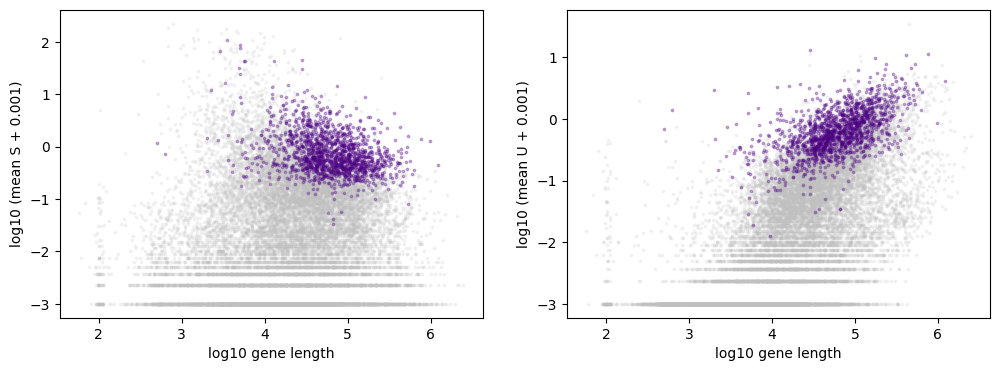

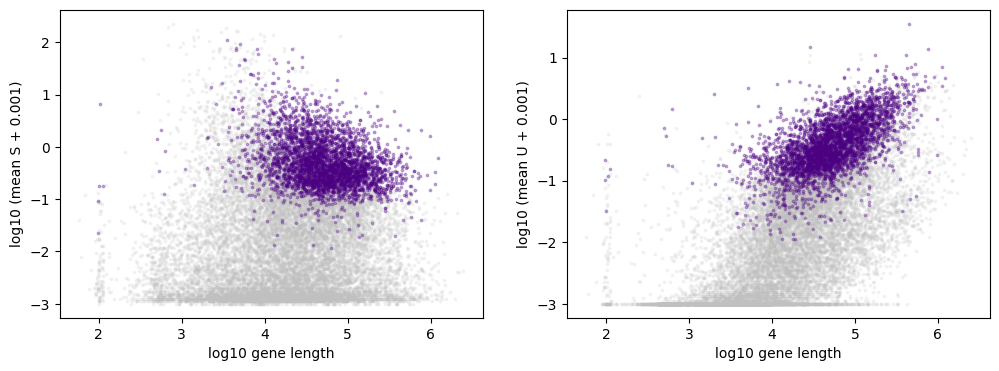

In [ ]:
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./',meta='crispra_combo',batch_id=1,\
                                             n_genes=500,exp_filter_threshold=None,cf=cf)

**Run *Monod* inference**

In [ ]:
#Define bounds for parameters
phys_lb = [-2.0, -1.8, -1.8 ] #lower bounds for b,beta,gamma (log10)
phys_ub = [4.2, 2.5, 2.5] #upper bounds for b,beta,gamma
samp_lb = [-7.157894736842105, -1.25] #lower bounds for sampling parameters (c_u,lambda_s)
samp_ub = [-7.157894736842105, -1.25] #upper bounds for sampling parameters (c_u,lambda_s)
gridsize = [1,1] #We are running the technical parameters used in the study (no grid search)

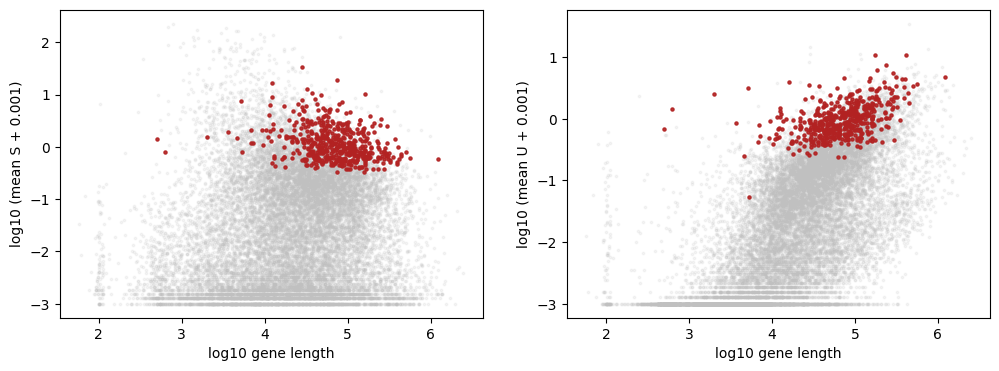

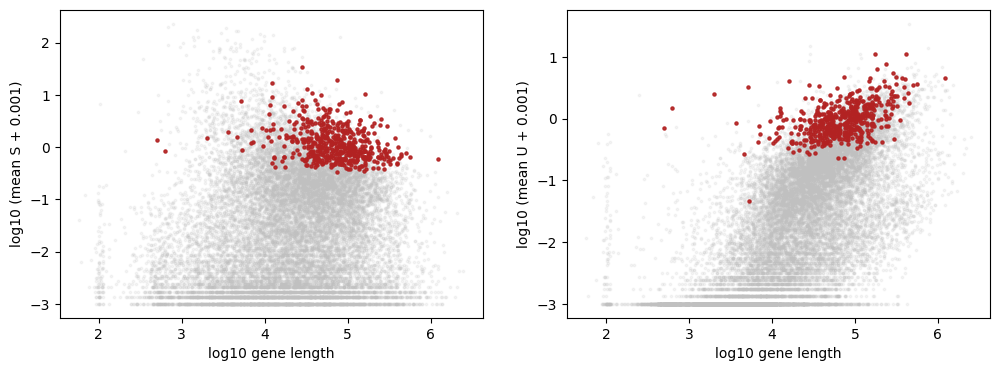

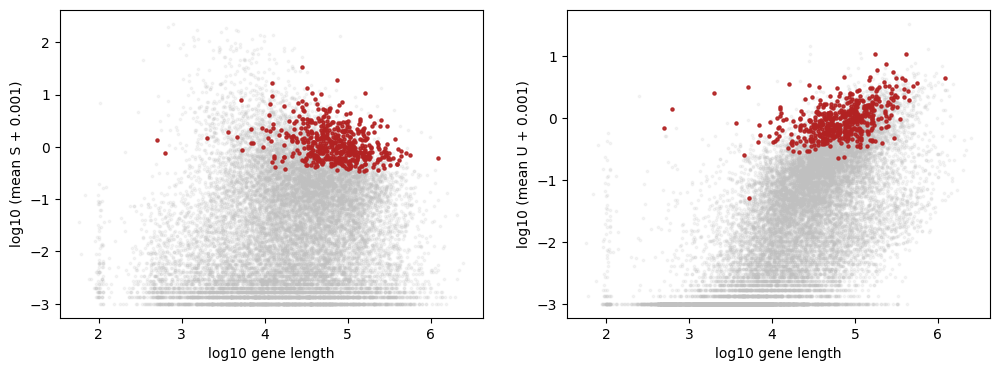

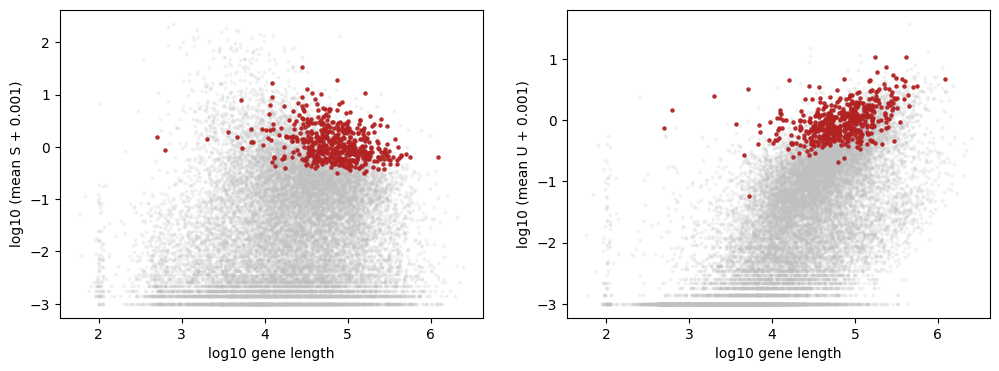

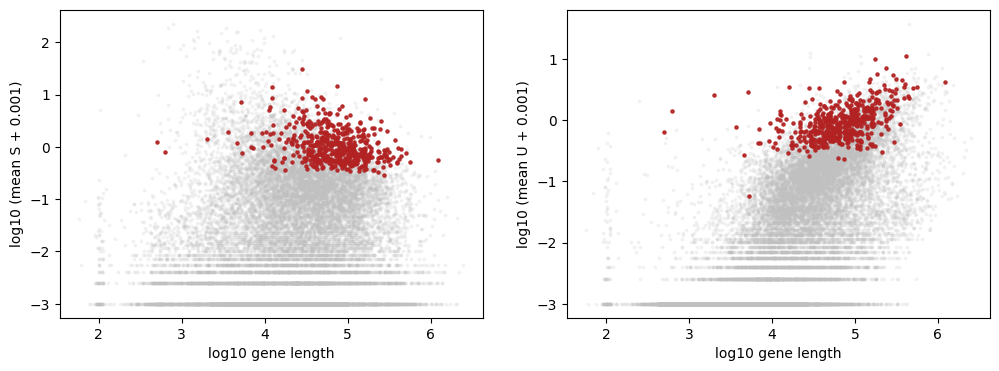

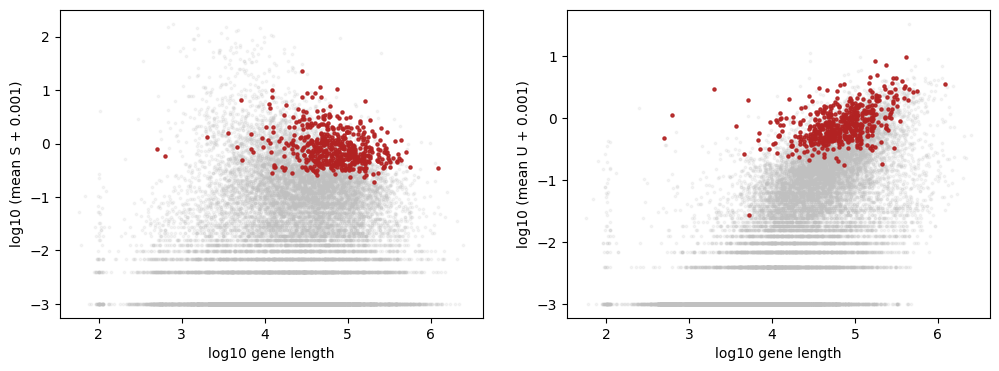

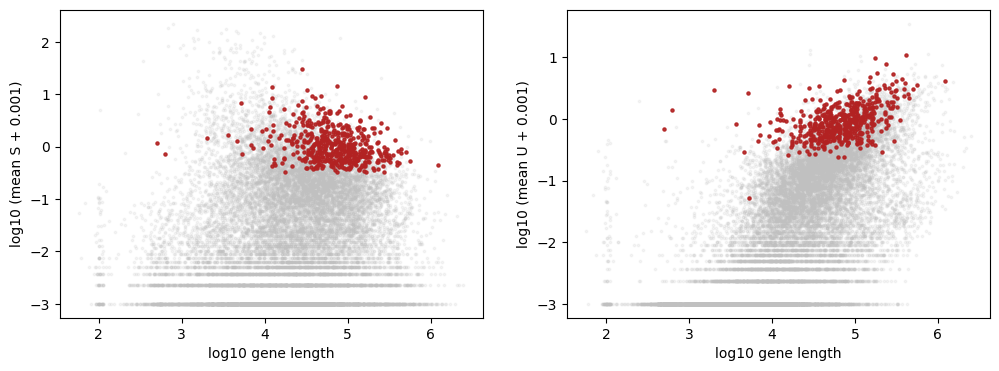

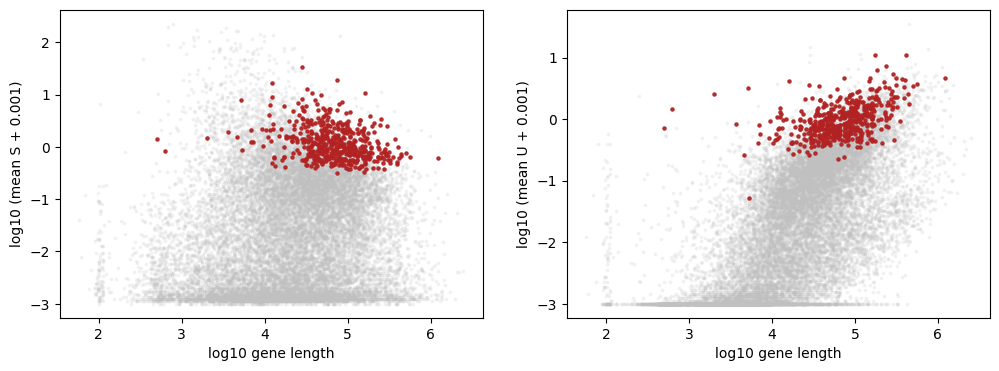

In [ ]:
result_strings = []
for i in range(n_datasets):
    #Set burst model with Poisson technical sampling
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')

    #Set up inference run
    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = True,
                gradient_params = {'max_iterations':5,'init_pattern':'moments','num_restarts':1})

    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, dataset_attr_names=attribute_names,cf=cf[i])
    #Run inference
    full_result_string = inference_parameters.fit_all_grid_points(1,search_data)

    result_strings.append(full_result_string)

In [ ]:
#Get rejection statistics
sr_arr = []
sd_arr = []
for i in range(n_datasets):
    sr = monod.analysis.load_search_results(result_strings[i])
    sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[i]+'/raw.sd')

    sr.find_sampling_optimum()


    _=sr.chisquare_testing(sd,threshold=1e-3)
    sr.chisq_best_param_correction(sd,Ntries=4,viz=False,threshold=1e-3)

    sr.compute_sigma(sd,num_cores=1)

    monod.analysis.make_batch_analysis_dir([sr],dir_string)
    sr.update_on_disk()

    sr_arr += [sr]
    sd_arr += [sd]

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
/usr/local/lib/python3.10/dist-packages/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, 

## **Multiplicative and Additive prediction models**

In [ ]:

#Check for genes where parameter fits are close to boundary of grid
def check_at_bounds(arr,phys_params,thr=0.01):
    x = np.any(np.logical_or(
        arr.sp.phys_lb+thr > phys_params,
        arr.sp.phys_ub-thr < phys_params) ,1)
    return x

def get_multAdd_annot(meanAdd,meanMult,true,trueErr,ci):
    '''
    Assign if param changes are mult/add/unknown.
    Compare predicted value from mult/add models to CI around observed/true value
    '''

    lb = true - ci*trueErr
    ub = true + ci*trueErr

    if (lb <= meanAdd <= ub) & (lb <= meanMult <= ub):
        return 'ambig'
    elif (lb <= meanAdd <= ub):
        return 'add'
    elif (lb <= meanMult <= ub):
        return 'mult'
    elif (meanAdd < lb) & (meanMult < lb):
        return 'supermult'
    elif (meanAdd > ub) & (meanMult > ub):
        return 'subadd'
    else:
        return 'ambig'




In [ ]:
def pred_params(vals,inds,model='mult'):
    '''
    Take in parameter fits from cond1/2, both and control, and indices for each dataset.
    Model is mult (multiplicative) as default, or add (additive)
    Output predictions, z: n_genes x n_params, and fits, true: n_genes x n_params.
    '''
    if model == 'add':
        #MODEL

        #Get previously fit parameter values,'ground truth'
        true = (vals[1,inds[2],:,:] - vals[1,inds[-1],:,:])


        z = np.log10(1/(1/(10**(vals[1,inds[0],:,:] - vals[1,inds[-1],:,:])) + 1/(10**(vals[1,inds[1],:,:] - vals[1,inds[-1],:,:])) -1))

        #Burst size additive model
        z[:,0] = np.log10(10**(vals[1,inds[0],:,0] - vals[1,inds[-1],:,0]) + 10**(vals[1,inds[1],:,0] - vals[1,inds[-1],:,0]) -1)


    else:
        #MODEL

        z = (vals[1,inds[0],:,:] - vals[1,inds[-1],:,:]) + (vals[1,inds[1],:,:] - vals[1,inds[-1],:,:])

        #Get previously fit parameter values,'ground truth'
        true = (vals[1,inds[2],:,:] - vals[1,inds[-1],:,:])


    return z,true


def pred_stds(vals,inds,ctrlInds,model='mult'):
    '''
    Take in parameter fits from cond1/2 and both (inds), and control inds (ctrlInds), and indices.
    Model is mult (multiplicative) as default, or add (additive)
    Output std dev of predictions/fits (z and true) per gene, n_genes x n_params.
    '''

    allZs = []
    allTrue = []

    for i in ctrlInds:
        inds_ctrl = inds+[i]
        z,true = pred_params(vals,inds_ctrl,model=model)

        allZs += [z]
        allTrue += [true]

    allPreds = np.concatenate(allZs)
    allTrues = np.concatenate(allTrue)

    #Convert to log2FC
    allPreds = np.log2(10**allPreds)
    allTrues = np.log2(10**allTrues)

    err_mat_preds = np.zeros((z.shape[0],3))
    err_mat_trues = np.zeros((z.shape[0],3))

    for j in range(err_mat_preds.shape[0]):
        var = np.var(allPreds[j,:],axis=0) #Var for each gene
        err_mat_preds[j,:] = np.sqrt(var)

        var = np.var(allTrues[j,:],axis=0) #Var for each gene
        err_mat_trues[j,:] = np.sqrt(var)

    return err_mat_preds,err_mat_trues, allPreds, allTrues

def get_multAdd_preds(par_vals,inds,ctrlInds,sd_arr,filt,mod=0,ci=1.96):
    '''
    Get expr FC (for mod=0 for U or 1 for S), and param FCs, under mult/add models
    '''
    ci = ci #confidence interval
    res = pd.DataFrame()

    #Mean spliced/unspliced preds
    meanU_add = np.log2(np.mean(sd_arr[inds[0]].layers[mod][filt,:],axis=1)/np.mean(sd_arr[inds[-1]].layers[mod][filt,:],axis=1) + np.mean(sd_arr[inds[1]].layers[mod][filt,:],axis=1)/np.mean(sd_arr[inds[-1]].layers[mod][filt,:],axis=1) -1)
    meanU_mult = np.log2(np.mean(sd_arr[inds[0]].layers[mod][filt,:],axis=1)/np.mean(sd_arr[inds[-1]].layers[mod][filt,:],axis=1))+np.log2(np.mean(sd_arr[inds[1]].layers[mod][filt,:],axis=1)/np.mean(sd_arr[inds[-1]].layers[mod][filt,:],axis=1))

    true_meanU = np.log2(np.mean(sd_arr[inds[2]].layers[mod][filt,:],axis=1)/np.mean(sd_arr[inds[-1]].layers[mod][filt,:],axis=1))
    true_meanU_err = np.std(np.array([np.log2(np.mean(sd_arr[inds[2]].layers[mod][filt,:],axis=1)/np.mean(sd_arr[ctrlInds[i]].layers[mod][filt,:],axis=1)) for i in range(len(ctrlInds))]),axis=0)/np.sqrt(len(ctrlInds))

    #Get mult/add assignment for means
    means_multAdd = [get_multAdd_annot(meanU_add[i],meanU_mult[i],true_meanU[i],true_meanU_err[i],ci) for i in range(meanU_add.shape[0])]


    z_mult,true  = pred_params(par_vals,inds,model='mult')

    std_z_mult, std_true, allPreds_mult, allTrues = pred_stds(par_vals,inds,ctrlInds,model='mult')
    std_true_err = std_true/np.sqrt(len(ctrlInds))

    z_add,true_add  = pred_params(par_vals,inds,model='add') #np.log2(10**Z)

    z_mult = z_mult[filt,:]
    true = true[filt,:]
    z_add = z_add[filt,:]
    std_true_err = std_true_err[filt,:]

    b_multAdd = [get_multAdd_annot(z_add[i,0],z_mult[i,0],true[i,0],std_true_err[i,0],ci) for i in range(meanU_add.shape[0])]
    beta_multAdd = [get_multAdd_annot(z_add[i,1],z_mult[i,1],true[i,1],std_true_err[i,1],ci) for i in range(meanU_add.shape[0])]

    res['gene'] = sd_arr[inds[0]].gene_names[filt]
    res['exprAnnot'] = means_multAdd
    res['exprFC'] = true_meanU
    res['bAnnot'] = b_multAdd
    res['betaAnnot'] = beta_multAdd
    res['bStd'] = std_true[filt,0]
    res['betaStd'] = std_true[filt,1]
    res['gammaStd'] = std_true[filt,2]

    res['bFC'] = np.log2(10**true[:,0])
    res['betaFC'] = np.log2(10**true[:,1])
    res['gammaFC'] = np.log2(10**true[:,2])

    return res


In [ ]:
#Save all biophysical parameters, and the control to compare all against
control = 7

n_genes = sr_arr[0].n_genes
n_phys_pars = sr_arr[0].sp.n_phys_pars
par_vals_uncorrected = np.zeros((2,n_datasets,n_genes,n_phys_pars))


for j in range(n_datasets):
    par_vals_uncorrected[0,j,:,:] = sr_arr[control].phys_optimum #control params
    par_vals_uncorrected[1,j,:,:] = sr_arr[j].phys_optimum


In [ ]:
for i in range(len(subcluster_names)):
    print(str(i)+' :'+str(subcluster_names[i]))

0 :['NegCtrl10_NegCtrl0__NegCtrl10_NegCtrl0']
1 :['NegCtrl11_NegCtrl0__NegCtrl11_NegCtrl0']
2 :['NegCtrl1_NegCtrl0__NegCtrl1_NegCtrl0']
3 :['NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0']
4 :['CBL_NegCtrl0__CBL_NegCtrl0']
5 :['CBL_CNN1__CBL_CNN1']
6 :['NegCtrl0_CNN1__NegCtrl0_CNN1', 'CNN1_NegCtrl0__CNN1_NegCtrl0']
7 :['NegCtrl10_NegCtrl0__NegCtrl10_NegCtrl0', 'NegCtrl11_NegCtrl0__NegCtrl11_NegCtrl0', 'NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0']


In [ ]:
ctrlInds = [0,1,3] #NegCtrl1 not used in original study
control=7

#Set which results are the individual and combined perturbation condition
inds = [4,6,5,control] #Single condition1, single condition 2, combined condition, control

In [ ]:
#Make filter for
cond1_res = sr_arr[inds[0]]
cond2_res = sr_arr[inds[1]]
both_res = sr_arr[inds[2]]
ctrl_res = sr_arr[inds[3]]
forFilt = ~cond1_res.rejected_genes & ~cond2_res.rejected_genes & ~both_res.rejected_genes & ~ctrl_res.rejected_genes

In [ ]:
res = get_multAdd_preds(par_vals_uncorrected,inds,ctrlInds,sd_arr,forFilt,mod=0,ci=1.96) #mod=0 unspliced, mod=1 spliced counts
res.head()

<ipython-input-24-24adb7a48a34>:14: RuntimeWarning: invalid value encountered in log10
  z = np.log10(1/(1/(10**(vals[1,inds[0],:,:] - vals[1,inds[-1],:,:])) + 1/(10**(vals[1,inds[1],:,:] - vals[1,inds[-1],:,:])) -1))
<ipython-input-24-24adb7a48a34>:17: RuntimeWarning: invalid value encountered in log10
  z[:,0] = np.log10(10**(vals[1,inds[0],:,0] - vals[1,inds[-1],:,0]) + 10**(vals[1,inds[1],:,0] - vals[1,inds[-1],:,0]) -1)


,gene,exprAnnot,exprFC,bAnnot,betaAnnot,bStd,betaStd,gammaStd,bFC,betaFC,gammaFC
0,TMEM59,subadd,-0.011630,ambig,ambig,0.219550,0.219550,0.219550,-0.093029,0.030779,0.442773
1,COPA,subadd,-0.182073,subadd,subadd,0.084398,0.084398,0.084398,0.024023,0.208429,0.086666
2,CLSPN,ambig,-0.341242,ambig,ambig,0.218909,0.218909,0.218909,0.540420,0.888982,1.108457
3,ZRANB2,subadd,-0.128204,subadd,subadd,0.182899,0.182899,0.182899,-1.504869,-1.296156,-1.066002
4,RC3H1,subadd,-0.316408,ambig,ambig,0.113746,0.113746,0.113746,-0.243892,0.052481,-0.079589


In [ ]:
#Save as csv
res.to_csv('multAdd_preds.csv',index=None)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='betaAnnot', ylabel='Count'>

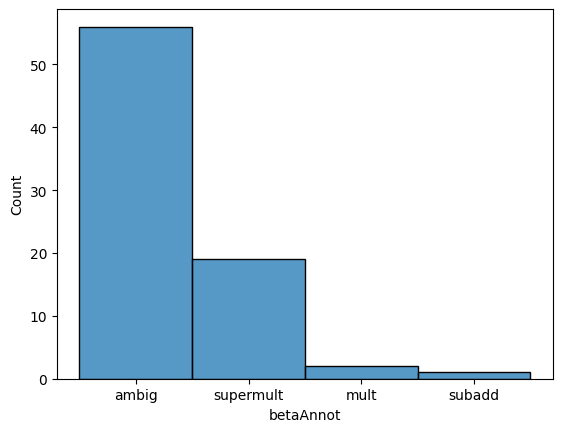

In [ ]:
#Distribution of strategies for beta fold changes for repressed genes (lowered expression)
sub = res[(res['exprFC'] <-0.5)]
sns.histplot(sub,x='betaAnnot')